## HT 3

Разработать систему мониторинга и алертинга для обнаружения различных типов дрифта в временных рядах метрик веб-сервиса. Найти истинные дрифты с минимальным количеством false алертов.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:

def visualize_generated_data(df, true_drifts):
    """
    Визуализация данных с отметками истинных дрифтов
    """
    metrics = ['requests', 'response_time', 'error_rate', 'cpu_usage']
    titles = [
        'Requests per Hour (drift at 700)',
        'Response Time ms (drifts at 500, 800)',
        'Error Rate % (drift at 600)',
        'CPU Usage % (drift at 750)'
    ]

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    for idx, (metric, title, ax) in enumerate(zip(metrics, titles, axes)):
        ax.plot(df.index, df[metric], linewidth=1, alpha=0.7, label='Data')

        # Отметки истинных дрифтов
        for drift_point in true_drifts[metric]:
            ax.axvline(x=drift_point, color='red', linestyle='--',
                      linewidth=2, alpha=0.7, label='True Drift' if drift_point == true_drifts[metric][0] else '')

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [3]:
df = pd.read_csv('drifts.csv')

In [4]:
true_drifts = {'requests': [700],
 'response_time': [500, 800],
 'error_rate': [600],
 'cpu_usage': [750]}

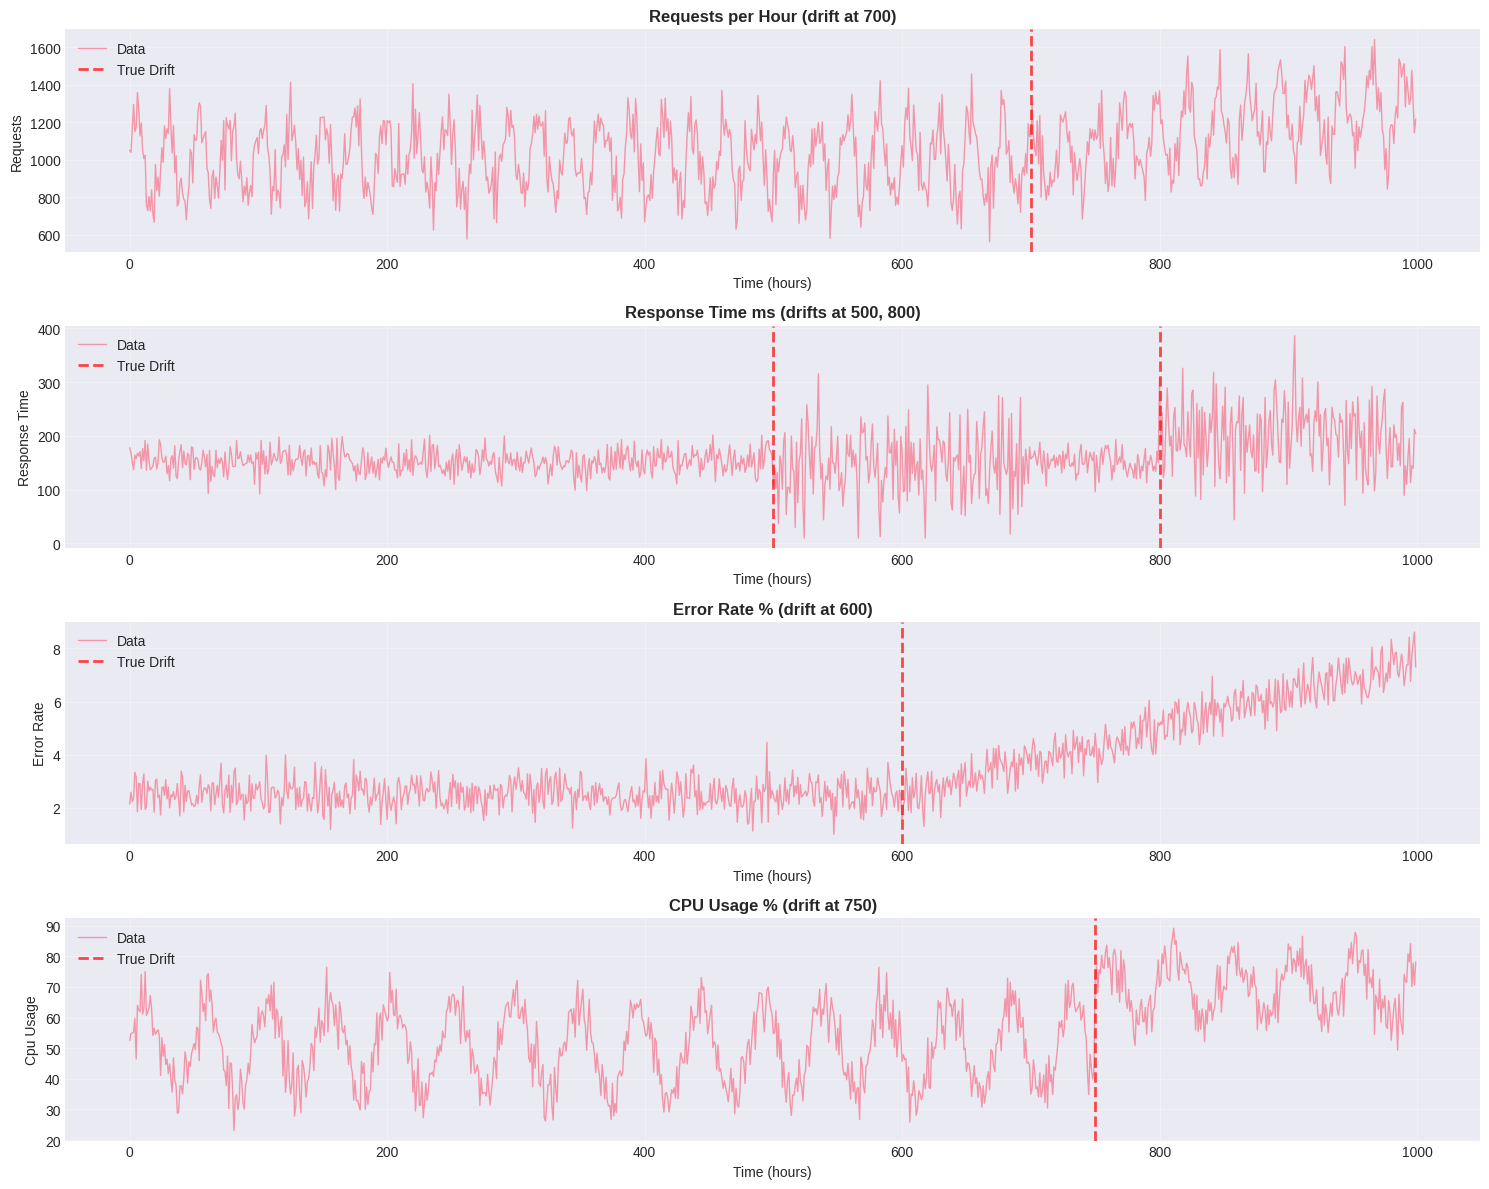

In [5]:
visualize_generated_data(df, true_drifts)

Исходные данные уже имеют метки истинных дрифтов, ваша задача - написать код, который с одной стороны определяет их как можно раньше, с другой стороны генерирует низкое количество ложных алеротов.

#### Задание 1

Выберите размеры окон и референсные периоды, реализуйте детекторы дрифта.

In [6]:
# 2. Детекторы дрифта
class DriftDetector:
    def __init__(self, reference_window_size=200):
        self.ref_size = reference_window_size

    def ks_test(self, reference, current, threshold=0.05):
        """Kolmogorov-Smirnov test"""
        statistic, p_value = stats.ks_2samp(reference, current)
        return p_value < threshold, p_value

    def psi(self, reference, current, bins=10):
        """Population Stability Index"""
        # TODO: реализовать
        pass

    def detect(self, data, current_idx, window_size=100):
        """Основной метод детекции"""
        # TODO: реализовать логику
        pass


#### Задание 2

Реализуйте логику алертов на основе дрифт детекторов, настройте пороги срабатывания

In [7]:
# 3. Система алертов
class AlertSystem:
    # TODO: реализовать
    pass


#### Задание 3

Оцените качество полученного решения и визуализируйте алерты.

In [8]:
# 4. Оценка качества
def evaluate_alerts(true_drift_points, detected_points, tolerance=50):
    """
    Оценка качества детекции
    tolerance: допустимая задержка обнаружения в точках
    fpr: доля false алертов
    """
    # TODO: реализовать
    pass

# 5. Визуализация
def plot_results(data, alerts, true_drift_points):
    # TODO: реализовать
    pass